# Clustering based on BYTES, PACKETS, DURATION

## Preparing a dataset

Load the dataset.

In [1]:
from cesnet_datazoo.datasets import CESNET_QUIC22

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS", silent=True)

Prepare the dataset with config and check its columns.

In [2]:
from cesnet_datazoo.config import DatasetConfig

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=100_000,
    use_packet_histograms=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)

data_df = dataset.get_train_df()
data_df.columns

Index(['PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

Add imports.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Prepare the dataset dataframe.
Convert APP column to APP_NAME.

In [4]:
data_df["APP_NAME"] = data_df["APP"].apply(lambda x: dataset._tables_app_enum.get(x, "Unknown"))

data_df["APP_NAME"].value_counts()

APP_NAME
bongacams                6830
cloudflare-cdnjs         6355
alza-identity            6323
flightradar24            6110
playradio                5551
                         ... 
google-authentication       9
instagram                   9
ebay-kleinanzeigen          9
google-autofill             8
uber                        7
Name: count, Length: 101, dtype: int64

Prepare function for saving renderings.

In [5]:
import os

APE_PICTURES_SAVED = False

plt.rcParams.update({'font.size': 26})

def save_fig_to_images_dir(fig, fig_name, images_dir=("images", "initial_clustering")):
    try:
        os.makedirs(os.path.join(*images_dir))
    except FileExistsError:
        pass
    
    try:
        fig.savefig(os.path.join(*images_dir, fig_name), dpi=300, bbox_inches='tight',
                    format='pdf', transparent=True, pad_inches=0.1)
        print(f"Figure {fig_name} saved successfully.")
    except Exception as e:
        print(f"Error saving figure {fig_name}: {e}")

## Feature extraction

Create new features.

In [6]:
data_df["BYTES_PER_PACKET"] = data_df["BYTES"] / data_df["PACKETS"]
data_df["BYTES_PER_PACKET_REV"] = data_df["BYTES_REV"] / data_df["PACKETS_REV"]

Get only the columns that are needed for clustering.

In [7]:
features_to_extract = ["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION", "PPI_LEN", "PPI_ROUNDTRIPS", "PPI_DURATION",
                       "BYTES_PER_PACKET", "BYTES_PER_PACKET_REV"]

features_array = data_df[features_to_extract].to_numpy()
app_array = data_df[["APP"]].to_numpy().reshape(-1)

## Preprocessing

Standardize the features.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

## KMeans

### Clustering

Cluster the data using KMeans NUMBER_OF_MULTIPLIERS (10) times.

In [9]:
from sklearn.cluster import KMeans

NUMBER_OF_MULTIPLIERS = 10

number_of_clusters = np.unique(app_array).shape[0]

kmeans_partitions = []

for cluster_multiplier in range(1, NUMBER_OF_MULTIPLIERS+1):
    kmeans = KMeans(n_clusters=number_of_clusters * cluster_multiplier, random_state=42)
    kmeans.fit(preprocessed_array)
    kmeans_partitions.append(kmeans.labels_)

### Evaluation

Plot homogeneity (purity) score.

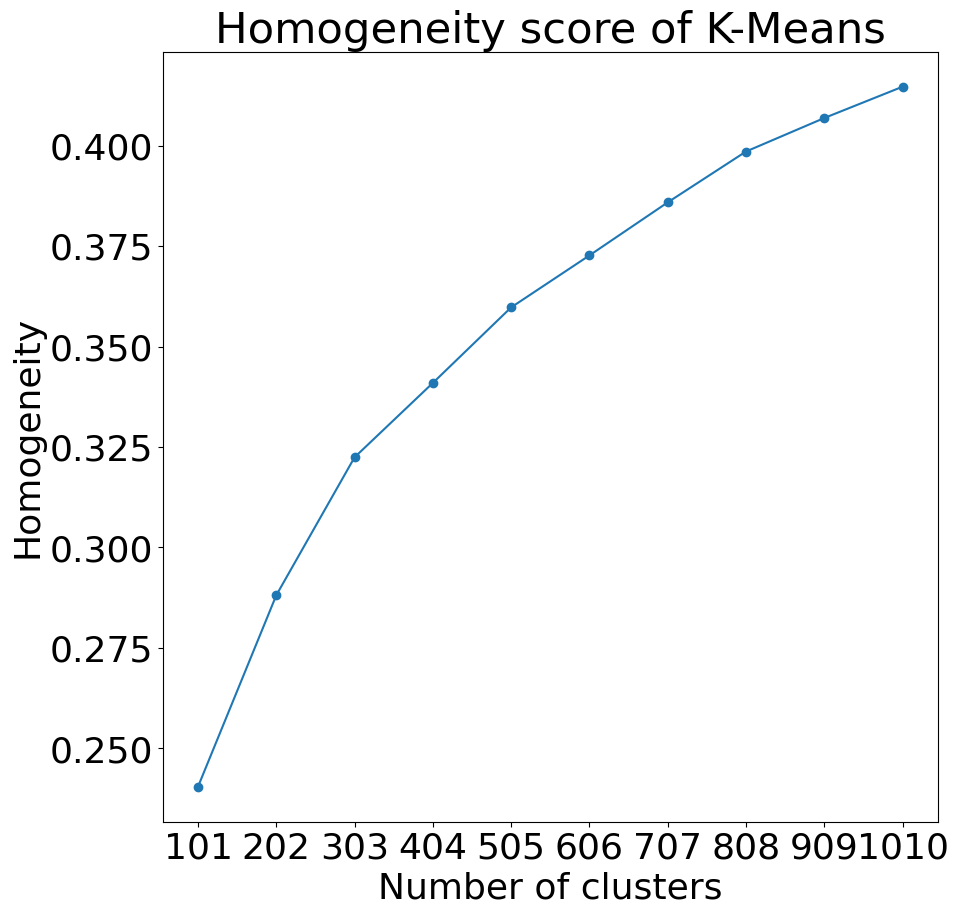

In [ ]:
from sklearn.metrics.cluster import homogeneity_score

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters), 
        [homogeneity_score(app_array, kmeans) for kmeans in kmeans_partitions], 
        marker='o')
ax.set_title("Homogeneity score of K-Means")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Homogeneity")
ax.set_xticks(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters))

if APE_PICTURES_SAVED: save_fig_to_images_dir(fig, "kmeans_homogeneity.pdf")

Plot NMI score.

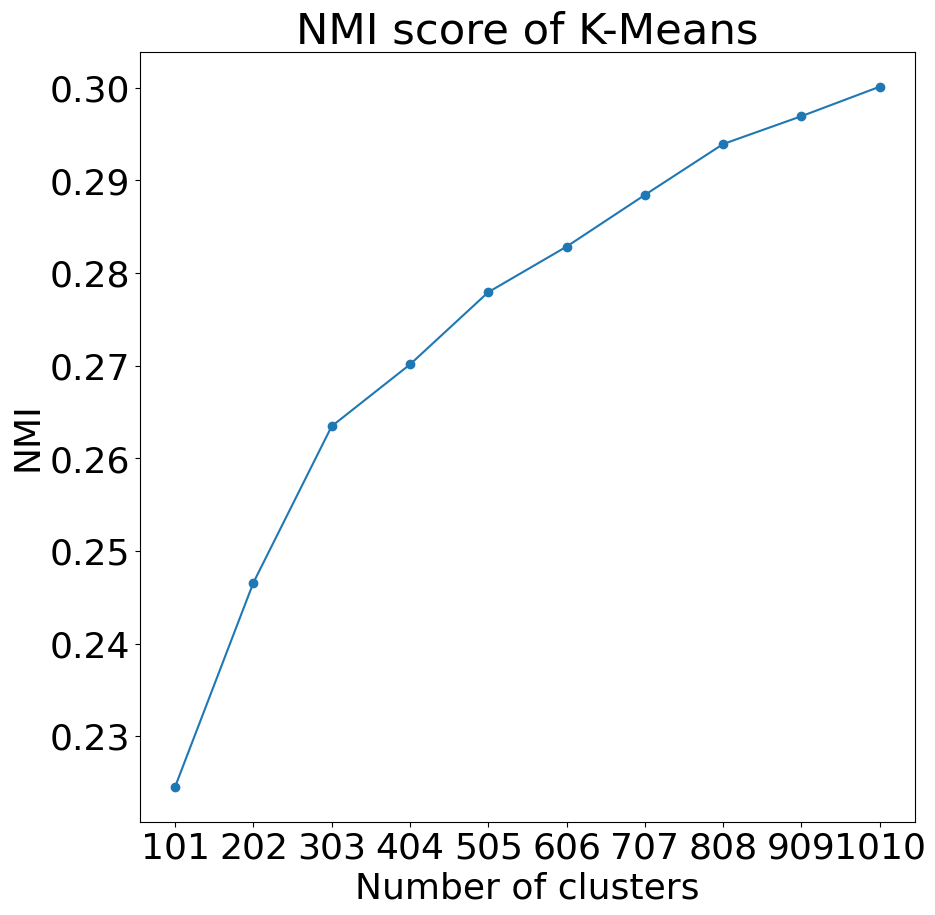

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score

plt.rcParams.update({'font.size': 26})
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters), 
        [normalized_mutual_info_score(app_array, kmeans) for kmeans in kmeans_partitions], 
        marker='o')
ax.set_title("NMI score of K-Means")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("NMI")
ax.set_xticks(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters))
plt.show()

if APE_PICTURES_SAVED: save_fig_to_images_dir(fig, "kmeans_nmi.pdf")

Show normalized pair confusion matrix.

In [12]:
from sklearn.metrics.cluster import pair_confusion_matrix

pair_confusion = pair_confusion_matrix(app_array, kmeans_partitions[0])
# divide everything by the number of packets
pair_confusion = pair_confusion / (np.sum(pair_confusion) - pair_confusion[0, 0])
pair_confusion[0, 0] = 0

pair_confusion

array([[0.        , 0.32850328],
       [0.62037146, 0.05112525]])

## HDBSCAN

### Clustering

Cluster the data using HDBSCAN.

In [13]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=7).fit(preprocessed_array)

### Evaluation

Check number of clusters.

In [14]:
np.unique(hdbscan.labels_)

array([  -1,    0,    1, ..., 2060, 2061, 2062])

Remove points that are marked as noise.

In [15]:
cleared_app_array = app_array[hdbscan.labels_ != -1]
cleared_hdbscan_labels = hdbscan.labels_[hdbscan.labels_ != -1]

f"HDBSCAN marked {hdbscan.labels_.shape[0] - cleared_hdbscan_labels.shape[0]} out of {hdbscan.labels_.shape[0]} packets as noise."

'HDBSCAN marked 51786 out of 100000 packets as noise.'

Show homogeneity (purity) score of HDBSCAN with noise and without noise.

In [16]:
homogeneity_score(app_array, hdbscan.labels_), homogeneity_score(cleared_app_array, cleared_hdbscan_labels)

(0.3243115745645198, 0.6691428906809924)

Show NMI score of HDBSCAN with noise and without noise.

In [17]:
normalized_mutual_info_score(app_array, hdbscan.labels_), normalized_mutual_info_score(cleared_app_array, cleared_hdbscan_labels)

(0.3070888325303831, 0.455146772595278)

Show pair confusion matrix of HDBSCAN without noise points.

In [18]:
pair_confusion = pair_confusion_matrix(cleared_app_array, cleared_hdbscan_labels)
# divide everything by the number of packets
pair_confusion = pair_confusion / (np.sum(pair_confusion) - pair_confusion[0, 0])
pair_confusion[0, 0] = 0

pair_confusion

array([[0.        , 0.13097876],
       [0.84954641, 0.01947483]])